In [1]:
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

Using TensorFlow backend.


In [2]:
from instance_normalization import InstanceNormalization

In [3]:
from keras.applications import *
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K
from keras.optimizers import RMSprop, SGD, Adam
import time
from IPython.display import clear_output
import cv2
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle
%matplotlib inline

## Configuration

In [4]:
K.set_learning_phase(1)

In [5]:
channel_axis=-1
channel_first = False

In [6]:
nc_in = 9
nc_out = 4
ngf = 64
ndf = 64
use_lsgan = False
use_nsgan = False # non-saturating GAN
λ = 10 if use_lsgan else 100

# ========== CAGAN config ==========
nc_G_inp = 9 # [x_im y_im y_j]
nc_G_out = 4 # [alpha, x_i_j(RGB)]
nc_D_inp = 6 # Pos: [x_i, y_i]; Neg1: [G_out(x_i), y_i]; Neg2: [x_i, y_j]
nc_D_out = 1 
gamma_i = 0.1
use_instancenorm = True

loadSize = 143
imageSize = 128
batchSize = 16 #1
lrD = 2e-4
lrG = 2e-4

## Define models

In [7]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization

In [13]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)

def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)

def instance_norm():
    return InstanceNormalization(axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)

def BASIC_D(nc_in, ndf, max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a =  Input(shape=(nc_in, None, None))
    else:
        input_a = Input(shape=(None, None, nc_in))
    _ = input_a
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid" if use_sigmoid else None) (_)    
    return Model(inputs=[input_a], outputs=_)



"""
Unet or Resnet, which one is better for pix2pix model? 
https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/117
Reply from the author:
    UNet gives slightly better results than Resnet in some of the pix2pix applications. 
    We haven't varied the depth of the UNet model, but it might be worth trying.
"""
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True, use_batchnorm=True):
    
    s = isize if fixed_input_size else None
    _ = inputs = Input(shape=(s, int(s*.75), nc_in))
    x_i = Lambda(lambda x: x[:, :, :, 0:3], name='x_i')(inputs)
    y_i = Lambda(lambda x: x[:, :, :, 3:6], name='y_j')(inputs)
    xi_and_y_i = concatenate([x_i, y_i], name = 'xi_yi')
    xi_yi_sz64 = AveragePooling2D(pool_size=2)(xi_and_y_i)
    xi_yi_sz32 = AveragePooling2D(pool_size=4)(xi_and_y_i)
    xi_yi_sz16 = AveragePooling2D(pool_size=8)(xi_and_y_i)
    xi_yi_sz8 = AveragePooling2D(pool_size=16)(xi_and_y_i)
    layer1 = conv2d(64, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'layer1') (_)
    layer1 = LeakyReLU(alpha=0.2)(layer1)
    layer1 = concatenate([layer1, xi_yi_sz64]) # ==========
    layer2 = conv2d(128, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'layer2') (layer1)
    if use_instancenorm:
        layer2 = instance_norm()(layer2, training=1)
    else:
        layer2 = batchnorm()(layer2, training=1)
    layer3 = LeakyReLU(alpha=0.2)(layer2)
    layer3 = concatenate([layer3, xi_yi_sz32]) # ==========
    layer3 = conv2d(256, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'layer3') (layer3)
    if use_instancenorm:
        layer3 = instance_norm()(layer3, training=1)
    else:
        layer3 = batchnorm()(layer3, training=1)
    layer4 = LeakyReLU(alpha=0.2)(layer3)
    layer4 = concatenate([layer4, xi_yi_sz16]) # ==========
    layer4 = conv2d(512, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'layer4') (layer4)
    if use_instancenorm:
        layer4 = instance_norm()(layer4, training=1)
    else:
        layer4 = batchnorm()(layer4, training=1)
    layer4 = LeakyReLU(alpha=0.2)(layer4)
    layer4 = concatenate([layer4, xi_yi_sz8]) # ==========
    
    layer9 = Conv2DTranspose(256, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init, name = 'layer9')(layer4) 
    layer9 = Cropping2D(((1,1),(1,1)))(layer9)
    if use_instancenorm:
        layer9 = instance_norm()(layer9, training=1)
    else:
        layer9 = batchnorm()(layer9, training=1)
    layer9 = Concatenate(axis=channel_axis)([layer9, layer3])
    layer9 = Activation('relu')(layer9)
    layer9 = concatenate([layer9, xi_yi_sz16]) # ==========
    layer10 = Conv2DTranspose(128, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init, name = 'layer10')(layer9) 
    layer10 = Cropping2D(((1,1),(1,1)))(layer10)
    if use_instancenorm:
        layer10 = instance_norm()(layer10, training=1)
    else:
        layer10 = batchnorm()(layer10, training=1)
    layer10 = Concatenate(axis=channel_axis)([layer10, layer2])
    layer10 = Activation('relu')(layer10)
    layer10 = concatenate([layer10, xi_yi_sz32]) # ==========
    layer11 = Conv2DTranspose(64, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init, name = 'layer11')(layer10) 
    layer11 = Cropping2D(((1,1),(1,1)))(layer11)
    if use_instancenorm:
        layer11 = instance_norm()(layer11, training=1)
    else:
        layer11 = batchnorm()(layer11, training=1)
    layer11 = Activation('relu')(layer11)
        
    layer12 = concatenate([layer11, xi_yi_sz64]) # ==========
    layer12 = Activation('relu')(layer12)
    layer12 = Conv2DTranspose(32, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init, name = 'layer12')(layer12) 
    layer12 = Cropping2D(((1,1),(1,1)))(layer12)
    if use_instancenorm:
        layer12 = instance_norm()(layer12, training=1)
    else:
        layer12 = batchnorm()(layer12, training=1)
    
    layer12 = conv2d(4, kernel_size=4, strides=1, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'out128') (layer12)
    
    alpha = Lambda(lambda x: x[:, :, :, 0:1], name='alpha')(layer12)
    x_i_j = Lambda(lambda x: x[:, :, :, 1:], name='x_i_j')(layer12)
    alpha = Activation("sigmoid", name='alpha_sigmoid')(alpha)
    x_i_j = Activation("tanh", name='x_i_j_tanh')(x_i_j)
    out = concatenate([alpha, x_i_j], name = 'out128_concat')
    
    return Model(inputs=inputs, outputs=[out])   

In [14]:
netGA = UNET_G(imageSize, nc_G_inp, nc_G_out, ngf)
#netGA.summary()

In [15]:
netDA = BASIC_D(nc_D_inp, ndf, use_sigmoid = not use_lsgan)
#netDA.summary()

## cycle_variables

In [16]:
def cycle_variables(netG1):
    """
    Intermidiate params:
        x_i: human w/ cloth i, shape=(128,96,3)
        y_i: stand alone cloth i, shape=(128,96,3)
        y_j: stand alone cloth j, shape=(128,96,3)
        alpha: mask for x_i_j, shape=(128,96,1)
        x_i_j: generated fake human swapping cloth i to j, shape=(128,96,3)
    
    Out:
        real_input: concat[x_i, y_i, y_j], shape=(128,96,9)
        fake_output: masked_x_i_j = alpha*x_i_j + (1-alpha)*x_i, shape=(128,96,3)
        rec_input: output of the second generator (generating image similar to x_i), shape=(128,96,3)
        fn_generate: a path from input to G_out and cyclic G_out
    """
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    # Legacy: how to split channels
    # https://github.com/fchollet/keras/issues/5474
    x_i = Lambda(lambda x: x[:,:,:, 0:3])(real_input)
    y_i = Lambda(lambda x: x[:,:,:, 3:6])(real_input)
    y_j = Lambda(lambda x: x[:,:,:, 6:])(real_input)
    alpha = Lambda(lambda x: x[:,:,:, 0:1])(fake_output)
    x_i_j = Lambda(lambda x: x[:,:,:, 1:])(fake_output)
    
    fake_output = alpha*x_i_j + (1-alpha)*x_i 
    concat_input_G2 = concatenate([fake_output, y_j, y_i], axis=-1) # swap y_i and y_j
    rec_input = netG1([concat_input_G2])
    rec_alpha = Lambda(lambda x: x[:,:,:, 0:1])(rec_input)
    rec_x_i_j = Lambda(lambda x: x[:,:,:, 1:])(rec_input)
    rec_input = rec_alpha*rec_x_i_j + (1-rec_alpha)*fake_output
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate, alpha

In [17]:
real_A, fake_B, rec_A, cycleA_generate, alpha_A = cycle_variables(netGA)

# Loss Function

In [18]:
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

In [19]:
def D_loss(netD, real, fake, rec):
    #x_i, y_i, y_j = tf.split(real, [3, 3, 3], 3)    
    x_i = Lambda(lambda x: x[:,:,:, 0:3])(real)
    y_i = Lambda(lambda x: x[:,:,:, 3:6])(real)
    y_j = Lambda(lambda x: x[:,:,:, 6:])(real)
    x_i_j = fake  
    
    output_real = netD(concatenate([x_i, y_i])) # positive sample
    output_fake = netD(concatenate([x_i_j, y_j])) # negative sample
    output_fake2 = netD(concatenate([x_i, y_j])) # negative sample 2
    
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))    
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_D_fake2 = loss_fn(output_fake2, K.zeros_like(output_fake2)) # New loss term for discriminator    
    if not use_nsgan:
        loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    else:
        loss_G = K.mean(K.log(output_fake))
    
    loss_D = loss_D_real+(loss_D_fake+loss_D_fake2)
    loss_cyc = K.mean(K.abs(rec-x_i)) # cycle loss
    return loss_D, loss_G, loss_cyc

In [20]:
loss_DA, loss_GA, loss_cycA = D_loss(netDA, real_A, fake_B, rec_A)
loss_cyc = loss_cycA
loss_id = K.mean(K.abs(alpha_A)) # loss of alpha

loss_G = loss_GA + 1*(1*loss_cyc + gamma_i*loss_id)
loss_D = loss_DA*2

weightsD = netDA.trainable_weights
weightsG = netGA.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_A],[loss_DA/2], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG,[], loss_G)
netG_train = K.function([real_A], [loss_GA, loss_cyc], training_updates)

# Load Image

Filenames:

    "./imgs/1/fileID_1.jpg" for human images.
    "./imgs/5/fileID_5.jpg" for article images.

In [28]:
isRGB = True
apply_da = True

In [36]:
def load_data(file_pattern):
    return glob.glob(file_pattern)

def crop_img(img, large_size, small_size):
    # only apply DA to human images
    img_width = small_size[0]
    img_height = small_size[1]
    diff_size = (large_size[0]-small_size[0], large_size[1]-small_size[1])
    
    x_range = [i for i in range(diff_size[0])]
    y_range = [j for j in range(diff_size[1])]
    x0 = np.random.choice(x_range)
    y0 = np.random.choice(y_range)
    
    img = np.array(img)
    
    img = img[y0: y0+img_height, x0: x0+img_width, :]
    
    return img

def read_image(fn):
    input_size = (111,148)
    cropped_size = (96,128)
    
    if isRGB:
    # Load human picture
        im = Image.open(fn).convert('RGB')
        im = im.resize( input_size, Image.BILINEAR )    
    else:
        im = cv2.imread(fn)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
        im = cv2.resize(im, input_size, interpolation=cv2.INTER_CUBIC)
    if apply_da is True:
        im = crop_img(im, input_size, cropped_size)
    arr = np.array(im)/255*2-1
    img_x_i = arr
    if channel_first:        
        img_x_i = np.moveaxis(img_x_i, 2, 0)
        
    # Load article picture y_i
    fn_y_i ="5.jpg"
    
    if isRGB:
        im = Image.open(fn_y_i).convert('RGB')
        im = im.resize(cropped_size, Image.BILINEAR )    
    else:
        im = cv2.imread(fn_y_i)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
        im = cv2.resize(im, cropped_size, interpolation=cv2.INTER_CUBIC)
    arr = np.array(im)/255*2-1
    img_y_i = arr
    if channel_first:        
        img_y_i = np.moveaxis(img_y_i, 2, 0)
    
    # Load article picture y_j randomly
    fn_y_j = np.random.choice(filenames_5)
    while (fn_y_j == fn_y_i):
        fn_y_j = np.random.choice(filenames_5)
    if isRGB:
        im = Image.open(fn_y_j).convert('RGB')
        im = im.resize( cropped_size, Image.BILINEAR )
    else:
        im = cv2.imread(fn_y_j)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
        im = cv2.resize(im, cropped_size, interpolation=cv2.INTER_CUBIC)
    arr = np.array(im)/255*2-1
    img_y_j = arr
    if randint(0,1): 
        img_y_j=img_y_j[:,::-1]
    if channel_first:        
        img_y_j = np.moveaxis(img_y_j, 2, 0)        
    
    if randint(0,1): # prevent disalign of the graphic on t-shirts and human when fplipping
        img_x_i=img_x_i[:,::-1]
        img_y_i=img_y_i[:,::-1]
    
    img = np.concatenate([img_x_i, img_y_i, img_y_j], axis=-1)    
    assert img.shape[-1] == 9
    
    return img

Get filenames

In [37]:
train_A = load_data('./bottoms/*.jpg')

filenames_1 = load_data('./bottoms/*.jpg')
filenames_5 = load_data('./hu/*.jpg')

print(len(train_A))
assert (len(train_A))

31


## Other utilities

In [38]:
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB(dataA, batchsize):
    batchA=minibatch(dataA, batchsize)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        tmpsize = yield ep1, A

In [39]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    #print (int_X.shape)
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,128,96), 1, 3)
    else:
        if X.shape[-1] == 9:
            img_x_i = int_X[:,:,:,:3]
            img_y_i = int_X[:,:,:,3:6]
            img_y_j = int_X[:,:,:,6:9]
            int_X = np.concatenate([img_x_i, img_y_i, img_y_j], axis=1)
        else:
            int_X = int_X.reshape(-1,128,96, 3)
    int_X = int_X.reshape(rows, -1, 128, 96,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    if not isRGB:
        int_X = cv2.cvtColor(int_X, cv2.COLOR_LAB2RGB)
    display(Image.fromarray(int_X))

In [40]:
def showG(A):
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]        
    rA = G(cycleA_generate, A)
    arr = np.concatenate([A[:,:,:,:3], A[:,:,:,3:6], A[:,:,:,6:9], rA[0], rA[1]])
    showX(arr,5)  

# Training

Show results every 50 iterations.

[4/15][5] Loss_D: 1.426955 Loss_G: 1.566741 loss_cyc: 0.567698 207.03038382530212


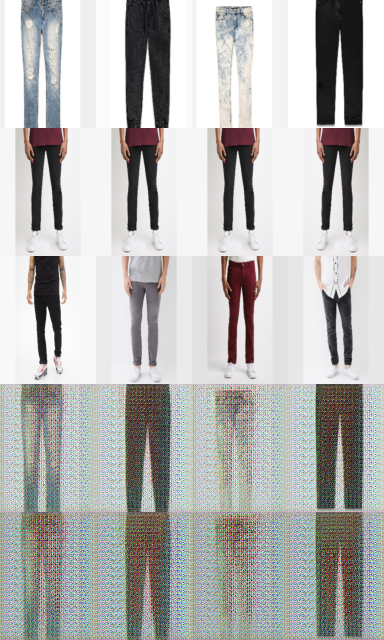

[9/15][10] Loss_D: 1.036785 Loss_G: 1.274268 loss_cyc: 0.512673 320.32937502861023


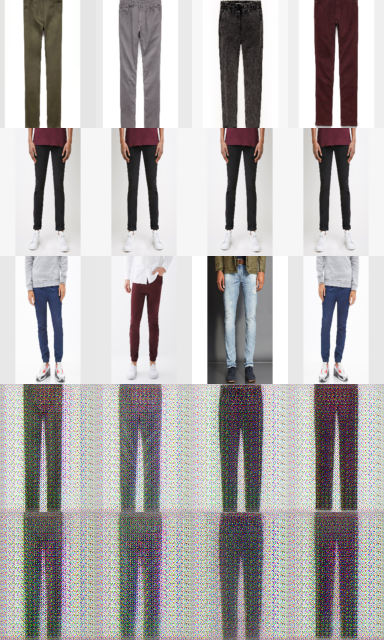

[14/15][15] Loss_D: 0.825761 Loss_G: 1.332756 loss_cyc: 0.425451 542.3337242603302


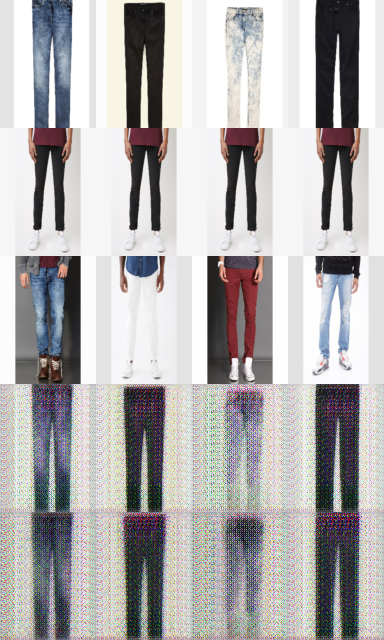

In [ ]:
t0 = time.time()
niter = 15
gen_iterations = 0
epoch = 0
errCyc_sum = errGA_sum = errDA_sum = errC_sum = 0

display_iters = 5
train_batch = minibatchAB(train_A, batchSize)

#while epoch < niter: 
while gen_iterations < 50:
    epoch, A = next(train_batch)   
    errDA  = netD_train([A])
    errDA_sum +=errDA[0]

    # epoch, trainA, trainB = next(train_batch)
    errGA, errCyc = netG_train([A])
    errGA_sum += errGA
    errCyc_sum += errCyc
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        if gen_iterations%(10*display_iters)==0: # clear_output every 500 iters
            clear_output()
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_cyc: %f'
        % (epoch, niter, gen_iterations, errDA_sum/display_iters,
           errGA_sum/display_iters, errCyc_sum/display_iters), time.time()-t0)        
        _, A = train_batch.send(4)
        showG(A)        
        errCyc_sum = errGA_sum = errDA_sum = errC_sum = 0

# Demo

Show 8 results on the same target article.

In [ ]:
def minibatch_demo(data, batchsize, fn_y_i=None):
    length = len(data)
    epoch = i = 0
    tmpsize = None
    shuffle(data)
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1    
        rtn = [read_image(data[j], fn_y_i) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB_demo(dataA, batchsize, fn_y_i=None):
    batchA=minibatch_demo(dataA, batchsize, fn_y_i=fn_y_i)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        tmpsize = yield ep1, A

In [ ]:
len_fn = len(filenames_5)
assert len_fn > 0
idx = np.random.randint(len_fn)
fn = filenames_5[idx]

demo_batch = minibatchAB_demo(train_A, batchSize, fn)
epoch, A = next(demo_batch) 

In [ ]:
_, A = demo_batch.send(8)
showG(A)